In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Sklearn functions
from sklearn.linear_model import ElasticNetCV, LinearRegression, Ridge, RidgeCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, PolynomialFeatures, RobustScaler, FunctionTransformer, PowerTransformer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Statsmodel functions
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

# Suppress warnings to keep output clean
import warnings
warnings.filterwarnings("ignore")


#Define random seed
np.random.seed(67)
random_seed = 67

---

<br>

# Data Extraction

In [93]:
# =============================================================================
# Loading both databases in Pandas using read_csv for faster testing
# We saved the CSVs after running the SQL once for the block range specified below
"""
cur.execute("SET min_block_id = 379899000") 
cur.execute("SET max_block_id = 380000000")
cur.execute("SET max_limit   =  100000000000")
cur.execute("SET min_season_block = 300000000")
cur.execute("SET max_season_block = 380000000")
"""
# =============================================================================

# To avoid having to reload the whole main_df with the SQL every time we edit main_df, we usually started the code from here for tests
main_df = pd.read_csv("data_100k.csv")
seasonality_df = pd.read_csv("seasonality_complete.csv")

In [94]:
# =============================================================================
# Merging seasonality avg priority fee per 30m block into main dataframe
# =============================================================================

# Creating a new column "hour" in both dataframes corresponding to the hour and minute of the 30m block timestamp
seasonality_df["hour"] = pd.to_datetime(seasonality_df['BLOCK_TS_30M']).dt.strftime('%H:%M')
seasonality_df = seasonality_df.drop(columns=["BLOCK_TS_30M"])

main_df["hour"] = pd.to_datetime(main_df['BLOCK_TS_30M']).dt.strftime('%H:%M')
main_df = main_df.drop(columns=["BLOCK_TS_30M"])

# Computing average priority fee per 30m across the seasonality dataframe
df_hourly = (
    seasonality_df.groupby('hour', as_index=False)['PRIORITY_FEE']
      .mean()
      .rename(columns={'PRIORITY_FEE': 'avg_priority_fee'})
)

# Merging the avg priority fee per 30m block into the main dataframe
main_df = main_df.merge(df_hourly, on = "hour", how = "left")

In [95]:
# =============================================================================
# Grouping by block
# =============================================================================


# Convert column names to lowercase to match the code expectations
main_df.columns = main_df.columns.str.lower()

# Rename columns to match expected names
main_df.rename(columns={'block': 'BLOCK', 'priority_fee': 'PRIORITY_FEE'}, inplace=True)

# Define the quantile we want to predict (90th percentile of priority fees)
q = 0.9

# Group data by BLOCK and compute the quantile fee for each block
df_block = (
    main_df.groupby("BLOCK")
    .agg(
        {
            "volume": "first",
            "avg_balance": "first",
            "tx_count_in_block": "first",
            "total_transactions": "first",
            "total_fee": "first",
            "units_consumed": "first",
            "avg_volume_last_999": "first",
            "avg_priority_fee": "first",
            "fksff_price": "first",
            "pct_diff_czfq3_fksff": "first",
            "pct_diff_czfq3_db3su": "first",
            "pct_diff_czfq3_n9vhc": "first",
            "pct_diff_czfq3_avgef": "first",
            "pct_diff_czfq3_ucnos": "first",
            "pct_diff_czfq3_vs_avg": "first",
            "sum_block_minus_1": "first",
            "sum_block_minus_2": "first",
            "sum_block_minus_3": "first",
            "sum_block_minus_4": "first",
            "sum_block_minus_5": "first",
            "sum_block_minus_6": "first",
            "sum_block_minus_7": "first",
            "sum_block_minus_8": "first",
            "sum_block_minus_9": "first",
            "sum_block_minus_10": "first",
            "avg_block_minus_1": "first",
            "avg_block_minus_2": "first",
            "avg_block_minus_3": "first",
            "avg_block_minus_4": "first",
            "avg_block_minus_5": "first",
            "avg_block_minus_6": "first",
            "avg_block_minus_7": "first",
            "avg_block_minus_8": "first",
            "avg_block_minus_9": "first",
            "avg_block_minus_10": "first",
            "PRIORITY_FEE": lambda x: np.quantile(x, q, interpolation="linear"),
        }
    )
    .reset_index()
)

---

<br>

# Data Cleaning

In [96]:
# =============================================================================
# Cleaning, feature engineering and preparation for modeling
# =============================================================================

# Rename the aggregated PRIORITY_FEE column to quantile_fee for clarity
df_block.rename(columns={"PRIORITY_FEE": "quantile_fee"}, inplace=True)

# Handle potential missing values in the variables by filling with 0 (because they correspond to a null value)
df_block = df_block.fillna(0)

# Minimal clipping for training stability (keep extreme values for evaluation)
# Note: we do this step now, before the preprocessing of X features, to avoid having extreme outliers in lagged features
q1 = df_block["quantile_fee"].quantile(0.25)
q3 = df_block["quantile_fee"].quantile(0.75)
iqr = q3 - q1


# Standard Turkey upper fence (heavy outliers only)
upper_fence = q3 + 20 * iqr
print(f"Tukey upper fence: {upper_fence:.0f}")

print(f"Percentage of values above upper fence: {(df_block['quantile_fee'] > upper_fence).mean() * 10:.2f}%")
print(f"Average of values > {upper_fence:.0f}: {df_block.loc[df_block['quantile_fee'] > upper_fence, 'quantile_fee'].mean():.0f}")

# Store original unclipped values for evaluation comparison
df_block["quantile_fee_original"] = df_block['quantile_fee']

# Clip outliers to upper fence
df_block['quantile_fee'] = np.clip(df_block['quantile_fee'], 0, upper_fence)

# Add engineered features based on block number
df_block["block_trend"] = df_block["BLOCK"] - df_block["BLOCK"].min()

# Create 4 lag features (we chose 4 based on a correlation study later in the project)
num_lags = 4
for lag in range(1, num_lags + 1):
    df_block[f"quantile_fee_lag_{lag}"] = df_block["quantile_fee"].shift(lag)


# Define features and target
features = [
    "volume",
    "tx_count_in_block",
    "avg_balance",
    "avg_priority_fee",
    "total_transactions",
    "total_fee",
    "units_consumed",
    "avg_volume_last_999",
    "fksff_price",
    "pct_diff_czfq3_fksff",
    "pct_diff_czfq3_db3su",
    "pct_diff_czfq3_n9vhc",
    "pct_diff_czfq3_avgef",
    "pct_diff_czfq3_ucnos",
    "pct_diff_czfq3_vs_avg",
    "sum_block_minus_1",
    "sum_block_minus_2",
    "sum_block_minus_3",
    "sum_block_minus_4",
    "sum_block_minus_5",
    "sum_block_minus_6",
    "sum_block_minus_7",
    "sum_block_minus_8",
    "sum_block_minus_9",
    "sum_block_minus_10",
    "avg_block_minus_1",
    "avg_block_minus_2",
    "avg_block_minus_3",
    "avg_block_minus_4",
    "avg_block_minus_5",
    "avg_block_minus_6",
    "avg_block_minus_7",
    "avg_block_minus_8",
    "avg_block_minus_9",
    "avg_block_minus_10",
    "block_trend",
] + [f"quantile_fee_lag_{i}" for i in range(1, num_lags + 1)]


# Drop first 20 rows containing NaN values resulting from lag feature creation + small margin
df_block = df_block.iloc[20:]

Tukey upper fence: 39642
Percentage of values above upper fence: 0.57%
Average of values > 39642: 285232


---

<br>

# Preprocessing

In [97]:
# =============================================================================
# Data Exploration
# =============================================================================

# Separating X and y
X = df_block[features]
y = df_block["quantile_fee"]

# Checking feature distributions and identifying skewed features in X
skewed_features = []
for i in X.columns:
    print(f"\033[1m{i}\033[0m")
    print(f"mean: {X[i].mean():.4f}")
    print(f"std: {X[i].std():.4f}")
    print(f"min: {X[i].min():.4f}")
    print(f"max: {X[i].max():.4f}")
    print(f"iqr: {X[i].quantile(0.75) - X[i].quantile(0.25):.4f}")
    print(f"skewness: {X[i].skew():.1f}")
    print("*" * 60)
    print("")
    if X[i].skew() > 4 and X[i].min() >= 0:
        skewed_features.append(i)

other_features = X.columns.difference(skewed_features)


# Checking target variable distribution and identifying skewness in y
print(f"\033[1mquantile fee\033[0m")
print(f"mean: {y.mean():.4f}")
print(f"std: {y.std():.4f}")
print(f"min: {y.min():.4f}")
print(f"max: {y.max():.4f}")
print(f"iqr: {y.quantile(0.75) - y.quantile(0.25):.4f}")
print(f"skewness: {y.skew():.1f}")

print(skewed_features)



volume
mean: 5481.5510
std: 14768.1757
min: 0.0000
max: 377277.7691
iqr: 5031.2480
skewness: 7.5
************************************************************

tx_count_in_block
mean: 5.3969
std: 4.0155
min: 0.0000
max: 49.0000
iqr: 4.0000
skewness: 2.1
************************************************************

avg_balance
mean: 4680297.5537
std: 353414.1333
min: 3892573.4024
max: 5779196.3911
iqr: 430577.2999
skewness: 0.1
************************************************************

avg_priority_fee
mean: 164462070.5448
std: 21409760.2593
min: 127762991.8450
max: 198571671.5684
iqr: 14084165.7744
skewness: 0.5
************************************************************

total_transactions
mean: 354.8109
std: 132.5774
min: 0.0000
max: 1537.0000
iqr: 143.0000
skewness: 1.9
************************************************************

total_fee
mean: 10766057.0989
std: 37794600.4940
min: 0.0000
max: 4739568042.0000
iqr: 6705776.0000
skewness: 108.5
***********************************

In [98]:
# =============================================================================
# Split and Preprocessing X
# =============================================================================

split_idx = int(0.8 * len(df_block))
# *******************************************

# Split X
X_train = X.iloc[:split_idx].copy()
X_test  = X.iloc[split_idx:].copy()
# *******************************************

# Quantile clipping
upper_X = X_train.quantile(0.99)
lower_X = X_train.quantile(0.01)

X_train_clip = X_train.clip(upper=upper_X,
                            lower=lower_X,
                            axis=1)

X_test_clip = X_test.clip(upper=upper_X,
                            lower=lower_X,
                            axis=1)
# ********************

# Log transform skewed features
X_train_log = X_train_clip.copy()
X_train_log[skewed_features] = np.log1p(X_train_clip[skewed_features])

X_test_log = X_test_clip.copy()
X_test_log[skewed_features] = np.log1p(X_test_clip[skewed_features])
# *******************************************

# RobustScale skewed features
rs = RobustScaler()

X_train_rs = X_train_log.copy()
X_train_rs[skewed_features] = rs.fit_transform(X_train_log[skewed_features])

X_test_rs = X_test_log.copy()
X_test_rs[skewed_features] = rs.transform(X_test_log[skewed_features])
# *******************************************

# Power transfrom other features
pt = PowerTransformer(method="yeo-johnson")

X_train_pt = X_train_rs.copy()
X_train_pt[other_features] = pt.fit_transform(X_train_pt[other_features])

X_test_pt = X_test_rs.copy()
X_test_pt[other_features] = pt.transform(X_test_pt[other_features])
# *******************************************

# Power transfrom all features without skewed separation
X_train_pta = X_train_clip.copy()
X_train_pta = pt.fit_transform(X_train_pta)

X_test_pta = X_test_clip.copy()
X_test_pta = pt.transform(X_test_pta)
# *******************************************

# Standard scale all features without skewed separation
ss = StandardScaler()

X_train_ss = X_train_clip.copy()
X_train_ss = ss.fit_transform(X_train_ss)

X_test_ss = X_test_clip.copy()
X_test_ss = ss.transform(X_test_ss)
# *******************************************


# Polynomial transform for later models
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_pt)
X_test_poly  = poly.transform(X_test_pt)


# =============================================================================
# Split and Preprocessing y
# =============================================================================

# Split y
y_train = y.iloc[:split_idx].copy()
y_test  = y.iloc[split_idx:].copy()
# *******************************************

# Log transform
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

---
<br>

# Baseline Models

In [99]:
# =============================================================================
# Naive Model Evaluation
# =============================================================================

mae_naive = np.mean(np.abs(y_test - y_train.mean()))
RMSE_naive = np.sqrt(np.mean((y_test - y_train.mean())**2))

print("Naive Model:")
print(f"Mean: {y.mean()}")
print(f"MAE: {mae_naive:.2f}")
print(f"RMSE: {RMSE_naive:.2f}")
print("=" * 60)
print("")


# =============================================================================
# Linear Regression Model Training Without Preprocessing
# =============================================================================

linear_basic = LinearRegression(fit_intercept=True)
linear_basic.fit(X_train, y_train)

linear_basic_pred = linear_basic.predict(X_test)

print("Linear Regression MAE without Preprocessing:")
print(f"MAE: {mean_absolute_error(y_test, linear_basic_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_basic_pred):.2f}")
print("=" * 60)
print("")


# =============================================================================
# Linear Regression Model Training With X clipping
# =============================================================================

linear_basic = LinearRegression(fit_intercept=True)
linear_basic.fit(X_train_clip, y_train)

linear_basic_pred = linear_basic.predict(X_test_clip)

print("Linear Regression MAE with X clipping")
print(f"MAE: {mean_absolute_error(y_test, linear_basic_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_basic_pred):.2f}")
print("=" * 60)
print("")


# =============================================================================
# Linear Regression Model Training With X clipping & skewed log
# =============================================================================

linear_basic = LinearRegression(fit_intercept=True)
linear_basic.fit(X_train_log, y_train)

linear_basic_pred = linear_basic.predict(X_test_log)

print("Linear Regression MAE with X clipping & skewed log:")
print(f"MAE: {mean_absolute_error(y_test, linear_basic_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_basic_pred):.2f}")
print("=" * 60)
print("")


# =============================================================================
# Linear Regression Model Training With X clipping & skewed log + Robust Scaler
# =============================================================================

linear_basic = LinearRegression(fit_intercept=True)
linear_basic.fit(X_train_rs, y_train)

linear_basic_pred = linear_basic.predict(X_test_rs)

print("Linear Regression MAE with X clipping & skewed log + Robust Scaler:")
print(f"MAE: {mean_absolute_error(y_test, linear_basic_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_basic_pred):.2f}")
print("=" * 60)
print("")


# =============================================================================
# Linear Regression Model Training With X clipping & skewed log + Robust Scaler & other Yeo Johnson
# =============================================================================

linear_basic = LinearRegression(fit_intercept=True)
linear_basic.fit(X_train_pt, y_train)

linear_basic_pred = linear_basic.predict(X_test_pt)

print("Linear Regression MAE with X clipping & skewed log + Robust Scaler & other Yeo Johnson:")
print(f"MAE: {mean_absolute_error(y_test, linear_basic_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_basic_pred):.2f}")
print("=" * 60)
print("")


# =============================================================================
# Linear Regression Model Training With Yeo Johnson
# =============================================================================

linear_basic = LinearRegression(fit_intercept=True)
linear_basic.fit(X_train_pta, y_train)

linear_basic_pred = linear_basic.predict(X_test_pta)

print("Linear Regression MAE with Yeo Johnson:")
print(f"MAE: {mean_absolute_error(y_test, linear_basic_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_basic_pred):.2f}")
print("=" * 60)
print("")


# =============================================================================
# Linear Regression Model Training With X Standard Scaler
# =============================================================================

linear_basic = LinearRegression(fit_intercept=True)
linear_basic.fit(X_train_ss, y_train)

linear_basic_pred = linear_basic.predict(X_test_ss)

print("Linear Regression MAE with Standard Scaler:")
print(f"MAE: {mean_absolute_error(y_test, linear_basic_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_basic_pred):.2f}")
print("=" * 60)
print("")


# =============================================================================
# Linear Regression Model Training without X preprocessing and y log
# =============================================================================

linear = LinearRegression(fit_intercept=True)
linear.fit(X_train, y_train_log)

linear_pred_log = linear.predict(X_test)
linear_pred = np.expm1(linear_pred_log)

print("Linear Regression MAE without X preprocessing and y log:")
print(f"MAE: {mean_absolute_error(y_test, linear_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_pred):.2f}")
print("=" * 60)
print("")


# =============================================================================
# Linear Regression Model Training With X Standard Scaler and y log
# =============================================================================

linear_ss = LinearRegression(fit_intercept=True)
linear_ss.fit(X_train_ss, y_train_log)

linear_ss_pred_log = linear_ss.predict(X_test_ss)
linear_ss_pred = np.expm1(linear_ss_pred_log)


print("Linear Regression MAE with X Standard Scaler and y log:")
print(f"MAE: {mean_absolute_error(y_test, linear_ss_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_ss_pred):.2f}")
print("=" * 60)
print("")


# =============================================================================
# Linear Regression Model Training with full X preprocessing and y log
# =============================================================================

linear = LinearRegression(fit_intercept=True)
linear.fit(X_train_pt, y_train_log)

linear_pred_log = linear.predict(X_test_pt)
linear_pred = np.expm1(linear_pred_log)

print("Linear Regression MAE with X preprocessing and y log:")
print(f"MAE: {mean_absolute_error(y_test, linear_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_pred):.2f}")


Naive Model:
Mean: 3874.850940602205
MAE: 5072.09
RMSE: 9230.69

Linear Regression MAE without Preprocessing:
MAE: 3770.70
RMSE: 9487.94

Linear Regression MAE with X clipping
MAE: 4003.22
RMSE: 9372.27

Linear Regression MAE with X clipping & skewed log:
MAE: 3970.67
RMSE: 9375.11

Linear Regression MAE with X clipping & skewed log + Robust Scaler:
MAE: 3970.67
RMSE: 9375.11

Linear Regression MAE with X clipping & skewed log + Robust Scaler & other Yeo Johnson:
MAE: 4139.01
RMSE: 9324.03

Linear Regression MAE with Yeo Johnson:
MAE: 4265.82
RMSE: 9295.31

Linear Regression MAE with Standard Scaler:
MAE: 4003.22
RMSE: 9372.27

Linear Regression MAE without X preprocessing and y log:
MAE: 3524.20
RMSE: 9826.00

Linear Regression MAE with X Standard Scaler and y log:
MAE: 3506.93
RMSE: 9804.03

Linear Regression MAE with X preprocessing and y log:
MAE: 3483.14
RMSE: 9781.85


---
<br>

# Main Models

In [100]:
# =============================================================================
# Ridge Regression With Standard Scaler Model Training 
# =============================================================================

alphas = np.logspace(0, 5, 50)
ridge_ss = RidgeCV(alphas=alphas)
ridge_ss.fit(X_train_ss, y_train_log)

# =============================================================================
# Ridge Regression With Standard Scaler Model Evaluation
# =============================================================================

ridge_pred_log = ridge_ss.predict(X_test_ss)
ridge_ss_pred = np.expm1(ridge_pred_log)

print(f"Ridge Regressor MAE: {mean_absolute_error(y_test, ridge_ss_pred):.2f}")
print(f"Ridge Regressor RMSE: {root_mean_squared_error(y_test, ridge_ss_pred):.2f}")

Ridge Regressor MAE: 3506.96
Ridge Regressor RMSE: 9804.22


In [101]:
# =============================================================================
# Ridge Regression With full Preprocessing Model Training
# =============================================================================

alphas = np.logspace(0, 5, 50)
ridge = RidgeCV(alphas=alphas)
ridge.fit(X_train_pt, y_train_log)

# =============================================================================
# Ridge Regression With full Preprocessing Model Evaluation
# =============================================================================

ridge_pred_log = ridge.predict(X_test_pt)
ridge_pred = np.expm1(ridge_pred_log)

print(f"Ridge Regressor MAE: {mean_absolute_error(y_test, ridge_pred):.2f}")
print(f"Ridge Regressor RMSE: {root_mean_squared_error(y_test, ridge_pred):.2f}")

Ridge Regressor MAE: 3482.67
Ridge Regressor RMSE: 9782.43


In [102]:
# =============================================================================
# Ridge Regression Model Training with Polynomial Features
# =============================================================================

alphas = np.logspace(-2, 4, 20)
ridge_poly = RidgeCV(alphas=alphas)
ridge_poly.fit(X_train_poly, y_train_log)

# =============================================================================
# Ridge Regression Model Evaluation with Polynomial Features
# =============================================================================

ridge_poly_pred_log = ridge_poly.predict(X_test_poly)
ridge_poly_pred = np.expm1(ridge_poly_pred_log)

print(f"Ridge Regressor Polynomial MAE: {mean_absolute_error(y_test, ridge_poly_pred):.2f}")
print(f"Ridge Regressor Polynomial RMSE: {root_mean_squared_error(y_test, ridge_poly_pred):.2f}")

Ridge Regressor Polynomial MAE: 3471.46
Ridge Regressor Polynomial RMSE: 9734.22


In [103]:
# =============================================================================
# ElasticNetCV Regression Model Training
# =============================================================================

elastic = ElasticNetCV(
    l1_ratio=[0.2, 0.4, 0.6, 0.8],
    alphas=np.logspace(-2, 2, 30),
    max_iter=10000,
    cv=5,
    n_jobs=-1
)
elastic.fit(X_train_poly, y_train_log)

# =============================================================================
# ElasticNetCV Regression Model Evaluation
# =============================================================================

elastic_pred_log = elastic.predict(X_test_poly)
elastic_pred = np.expm1(elastic_pred_log)

print(f"ElasticNet Regressor Polynomial MAE: {mean_absolute_error(y_test, elastic_pred):.2f}")
print(f"ElasticNet Regressor Polynomial RMSE: {root_mean_squared_error(y_test, elastic_pred):.2f}")

ElasticNet Regressor Polynomial MAE: 3470.62
ElasticNet Regressor Polynomial RMSE: 9755.03


In [104]:
# =============================================================================
# Random Forest Regressor Model Training
# =============================================================================

forest = RandomForestRegressor(
    n_estimators=100,      
    max_depth=20,         
    min_samples_leaf=5,
    min_samples_split=10, 
    random_state=random_seed,
    n_jobs=-1             
)
forest.fit(X_train_pt, y_train_log)


# =============================================================================
# Random Forest Regressor Model Evaluation
# =============================================================================

forest_pred_log = forest.predict(X_test_pt)
forest_pred = np.expm1(forest_pred_log)

print(f"Random Forest MAE: {mean_absolute_error(y_test, forest_pred)}")
print(f"Random Forest RMSE: {root_mean_squared_error(y_test, forest_pred)}")


Random Forest MAE: 3475.836200900599
Random Forest RMSE: 9781.90307396043


In [105]:
# =============================================================================
# MLP Training with Hyperparameter Tuning
# =============================================================================

# Define parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(32, 64), (64,), (64, 64)],
    'alpha': np.logspace(0, 3, 8),
    'learning_rate_init': [3e-4, 1e-3],
    'max_iter': [1000]
}

# Create MLPRegressor instance
mlp_base = MLPRegressor(
    activation="relu",
    solver="adam",
    batch_size="auto",
    learning_rate="constant",
    validation_fraction=0.1,
    tol = 1e-4,
    random_state=random_seed,
    early_stopping=True
)

# Use TimeSeriesSplit for cross-validation on time series data
tscv = TimeSeriesSplit(n_splits=2)

# Perform GridSearchCV
random_search = RandomizedSearchCV(
    estimator=mlp_base,
    param_distributions=param_grid,
    n_iter=20,                       
    cv=3,                            
    n_jobs=-1,
    verbose=1,
    random_state=random_seed,
)
random_search.fit(X_train_ss, y_train_log)

# Get best parameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Create and configure the MLP Regressor with best parameters
mlp = MLPRegressor(
    **best_params,
    activation="relu",  
    solver="adam",  
    batch_size="auto",  
    learning_rate="constant",  
    random_state=random_seed, 
    early_stopping=True,  
)

# Train the model on the training data
mlp.fit(X_train_ss, y_train_log)


# =============================================================================
# MLP Evaluation
# =============================================================================

mlp_pred_log = mlp.predict(X_test_ss)
mlp_pred = np.expm1(mlp_pred_log)

print(f"MLP Regressor MAE: {mean_absolute_error(y_test, mlp_pred)}")
print(f"MLP Regressor RMSE: {root_mean_squared_error(y_test, mlp_pred)}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'max_iter': 1000, 'learning_rate_init': 0.0003, 'hidden_layer_sizes': (32, 64), 'alpha': np.float64(19.306977288832496)}
MLP Regressor MAE: 3493.0551070324886
MLP Regressor RMSE: 9782.854979239652


In [106]:
# ============================================================
#  ARIMA Model
# ============================================================

arima = ARIMA(y_train_log, order=(2, 1, 2))
fit = arima.fit()


# ============================================================
#  ARIMA Evaluation
# ============================================================

arima_pred_log = fit.forecast(steps=len(y_test_log))
arima_pred = np.expm1(arima_pred_log)

print(f"ARIMA MAE: {mean_absolute_error(y_test, arima_pred)}")
print(f"ARIMA RMSE: {root_mean_squared_error(y_test, arima_pred)}")


ARIMA MAE: 3536.948563187224
ARIMA RMSE: 9830.529558801703


---

<br>

# Data Visualization <br>

We now plot a few interesting graphs.
<br>

First, we plot autocorrelation between the target value and lagged features of different lag.

Next, we plot average priority fee per 30 min time of day. Although we can see clear trends, our models didn't cath on that signal. This is interesting, and we expect it is because of the relatively short time period of our main data coverage (only about 14 hours). Indeed, this time period didn't allow for at least a few full day rotations and variances from the mean hour trend have a huge impact and thus greatly reduce the training utility of this data. It would thus have been interesting to see how the models would have reacted with far greater dataframes (which we weren't able to do for computational reasons).

For the third graph, we show the target quantile fee before and after log transformation.

In the fourth plot, we display the top 10 most used features in the models, showing that short-term price differences are indeed a good indicator for optimal priority fee, supporting our initial thesis.

In the fifth plot, we display exactly the opposite, showing the bottom 10 least used features. Interesting, volume is rarely used in our models.

Next, we plot errors for our main models for different k clipping of original quantile fees.

Additionally, we plot actual and predicted quantile fees for a sample block.

Finally, we plot where our error comes from (from values above / below our prediction), showing that our error evaluation benchmarks blow off mainly due to very high values.


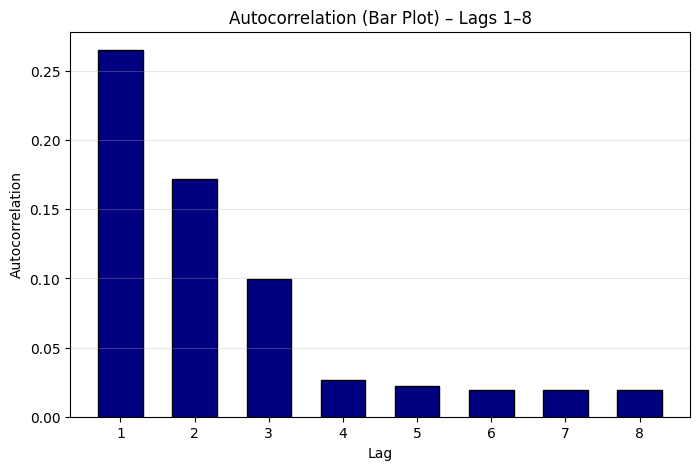

In [107]:
# =============================================================================
# Data Visualization
# =============================================================================

y_log = np.log1p(y)
# Compute ACF values (including lag 0)
acf_vals = acf(y_train_log, nlags=8)

# Remove lag 0 because it is always 1.0
lags = np.arange(1, 9)
acf_lags = acf_vals[1:]   

# Bar plot
plt.figure(figsize=(8,5))
plt.bar(lags, acf_lags, width=0.6, color='#000080', edgecolor="black")

plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation (Bar Plot) – Lags 1–8")
plt.grid(axis="y", alpha=0.3)
plt.xticks(lags)

plt.show()


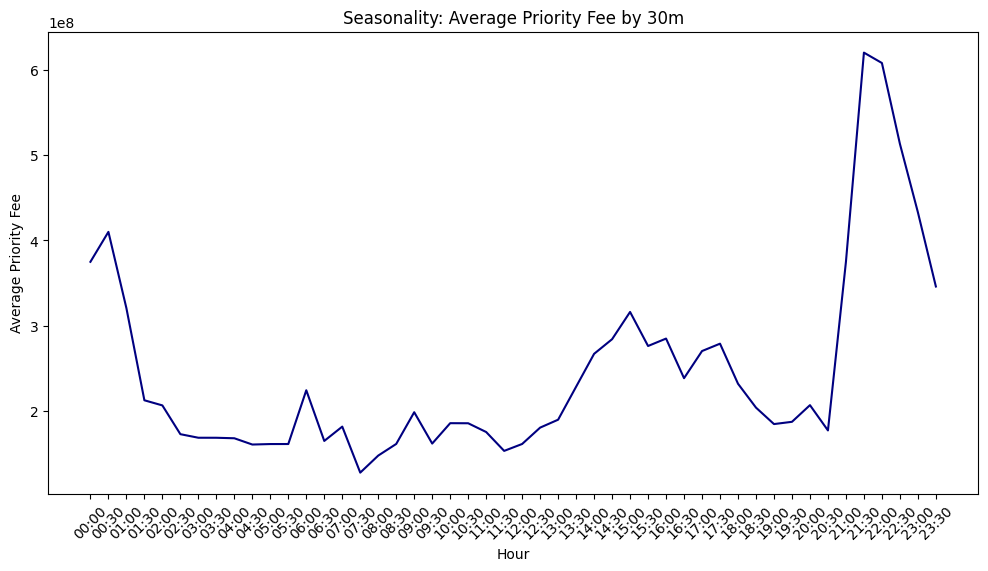

In [108]:
# Seasonality plot
plt.figure(figsize=(12, 6))
plt.plot(df_hourly['hour'], df_hourly['avg_priority_fee'], color='#000080')
plt.xlabel('Hour')
plt.ylabel('Average Priority Fee')
plt.title('Seasonality: Average Priority Fee by 30m')
plt.xticks(rotation=45)
plt.show()

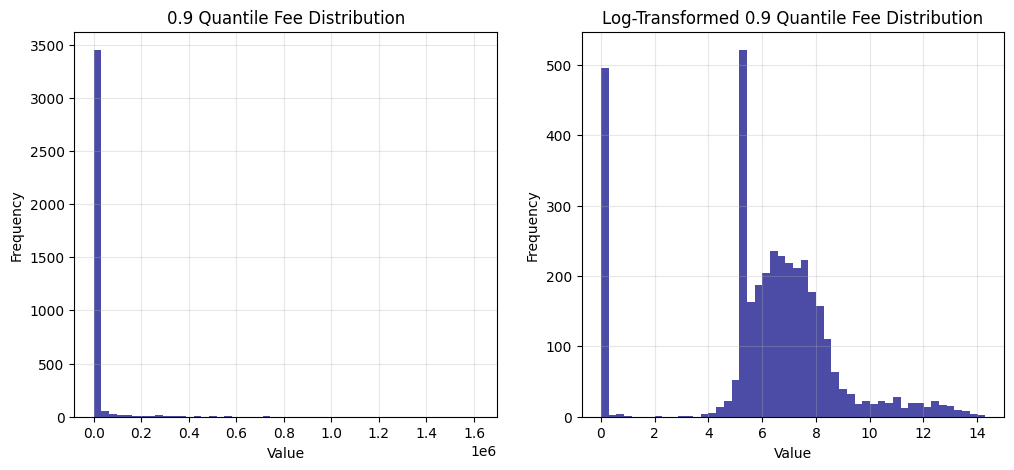

In [109]:
# Histogram comparison of raw vs log-transformed target variable

y_test_unclipped = df_block["quantile_fee_original"].iloc[split_idx:].values

# Histogram for log transformation on unclipped data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y_test_unclipped, bins=50, alpha=0.7, color='#000080')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('0.9 Quantile Fee Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(np.log1p(y_test_unclipped), bins=50, alpha=0.7, color='#000080')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log-Transformed 0.9 Quantile Fee Distribution')
plt.grid(True, alpha=0.3)

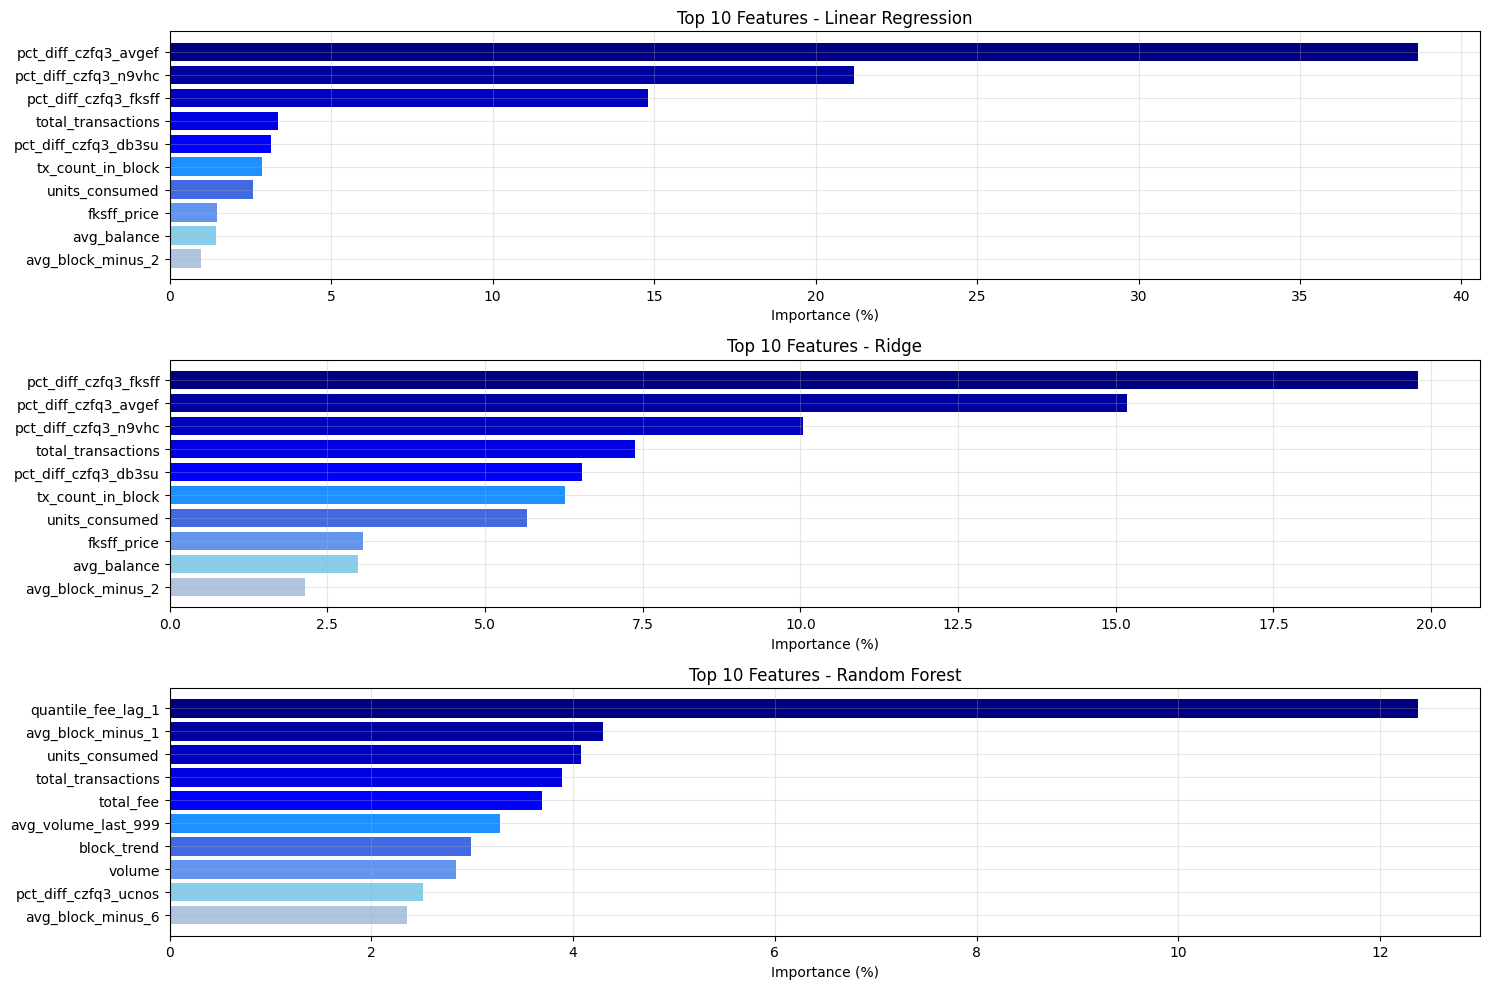

In [ ]:
# =============================================================================
# Model Visualization
# =============================================================================


# Get polynomial feature names for Ridge
poly_features = poly.get_feature_names_out(features)

# Define models and their importance getters, with appropriate feature lists
models_info = {
    "Linear Regression": (linear_ss, lambda m: np.abs(m.coef_), features),
    "Ridge": (ridge_ss, lambda m: np.abs(m.coef_), poly_features),
    "Random Forest": (forest, lambda m: m.feature_importances_, features),
}

# Define shades of blue (darker to lighter, excluding very light)
blue_shades = ['#000080', '#0000A0', '#0000C0', '#0000E0', '#0000FF', '#1E90FF', '#4169E1', '#6495ED', '#87CEEB', '#B0C4DE']

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
axes = axes.flatten()

for idx, (model_name, (model, getter, feat_list)) in enumerate(models_info.items()):
    ax = axes[idx]
    
    # Get importance
    importance = getter(model)
    importance_pct = (importance / importance.sum()) * 100
    
    # Get top 10
    top_indices = np.argsort(importance_pct)[-10:]        
    top_indices = top_indices[np.argsort(importance_pct[top_indices])[::-1]]
    top_features = [feat_list[i] for i in top_indices]
    top_pct = importance_pct[top_indices]
    
    # Plot horizontal bars with blue shades
    ax.barh(top_features[::-1], top_pct[::-1], color=blue_shades[::-1])  # Reverse for top at top
    ax.set_xlabel('Importance (%)')
    ax.set_title(f'Top 10 Features - {model_name}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

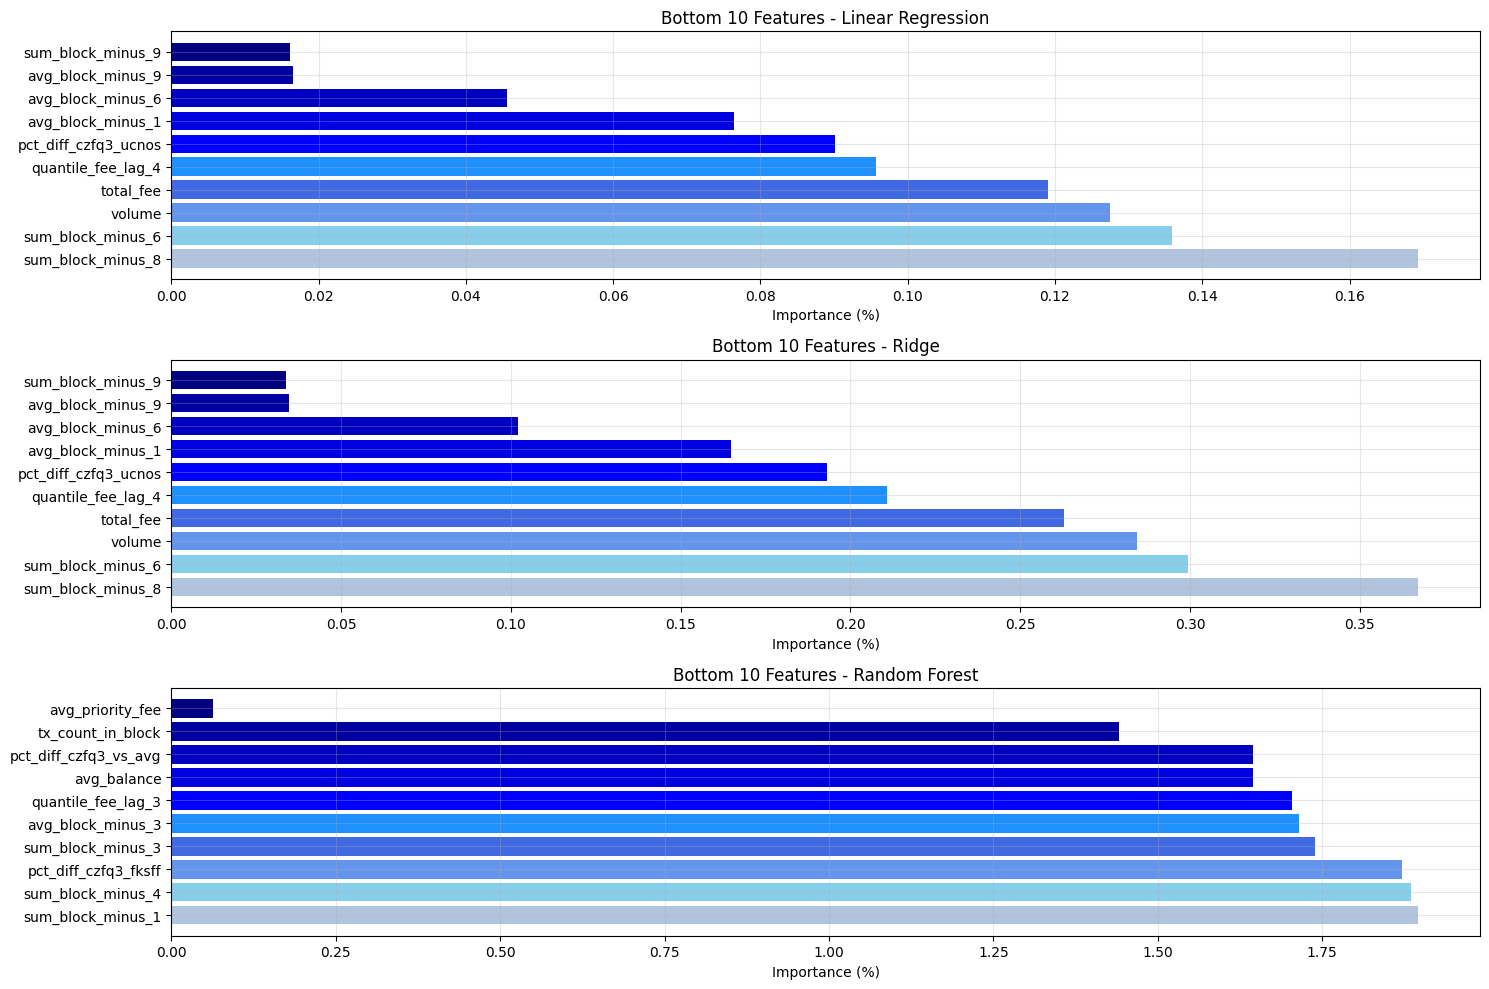

In [122]:
# =============================================================================
# Model Visualization (Corrected Bottom-10 Sorting)
# =============================================================================

# Get polynomial feature names for Ridge
poly_features = poly.get_feature_names_out(features)

models_info = {
    "Linear Regression": (linear_ss, lambda m: np.abs(m.coef_), features),
    "Ridge": (ridge_ss, lambda m: np.abs(m.coef_), poly_features),
    "Random Forest": (forest, lambda m: m.feature_importances_, features),
}

# Same color palette
blue_shades = ['#000080', '#0000A0', '#0000C0', '#0000E0', '#0000FF',
               '#1E90FF', '#4169E1', '#6495ED', '#87CEEB', '#B0C4DE']

fig, axes = plt.subplots(3, 1, figsize=(15, 10))
axes = axes.flatten()

for idx, (model_name, (model, getter, feat_list)) in enumerate(models_info.items()):
    ax = axes[idx]
    
    # Importance
    importance = getter(model)
    importance_pct = (importance / importance.sum()) * 100
    
    # ---- CORRECTED: get bottom 10 properly ----
    # Smallest 10 values (least important)
    bottom_indices = np.argsort(importance_pct)[:10]
    
    # Sort them ASCENDING so the MOST USELESS is last
    bottom_indices = bottom_indices[np.argsort(importance_pct[bottom_indices])]
    
    # Prepare labels and values
    bottom_features = [feat_list[i] for i in bottom_indices]
    bottom_pct = importance_pct[bottom_indices]
    
    # ---- Plot ----
    ax.barh(bottom_features[::-1],      # reverse so smallest importance is at TOP
            bottom_pct[::-1],           # same reversal
            color=blue_shades[::-1])    # same color styling
    
    ax.set_xlabel('Importance (%)')
    ax.set_title(f'Bottom 10 Features - {model_name}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Q1: 214.0, Q3: 2091.1000000000004, IQR: 1877.1000000000004
MAE for each model under different IQR k clipping thresholds:
             Linear Regression         Ridge  Random Forest           MLP  \
k=1.5              1169.116743   1168.642176    1161.811331   1179.030237   
k=3                1452.786581   1452.312014    1445.481169   1462.700075   
k=5                1761.396864   1760.922297    1754.091452   1771.310358   
k=10               2413.753952   2413.279385    2406.448540   2423.667446   
k=20               3482.706296   3482.231729    3475.400884   3492.619790   
k=50               5811.973502   5811.498935    5804.668090   5821.886996   
No Clipping       14990.714275  14990.239708   14983.408863  15000.627769   

                    ARIMA         Naive  
k=1.5         1222.923693   2758.069649  
k=3           1506.593532   3041.739487  
k=5           1815.203814   3350.349769  
k=10          2467.560902   4002.706857  
k=20          3536.513246   5071.659202  
k=50      

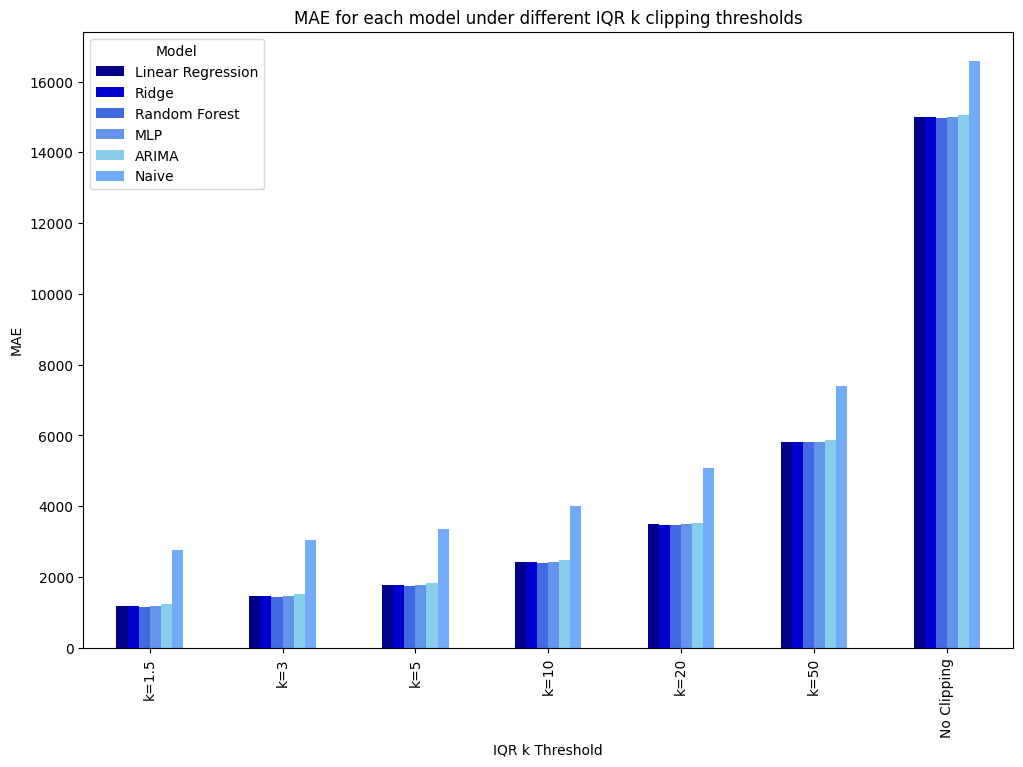

In [118]:
# =============================================================================
# Clipping Visualization
# =============================================================================



# Create table for MAE with different IQR k clipping thresholds on actuals and predictions



# Compute IQR from original unclipped data
q1 = df_block["quantile_fee_original"].quantile(0.25)
q3 = df_block["quantile_fee_original"].quantile(0.75)
iqr = q3 - q1



print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}")



# Use unclipped test actuals for evaluation
y_test_unclipped = df_block["quantile_fee_original"].iloc[split_idx:].values



# Define models and their predictions
models = {
    "Linear Regression": linear_pred,
    "Ridge": ridge_pred,
    "Random Forest": forest_pred,
    "MLP": mlp_pred,
    "ARIMA": arima_pred,
    "Naive": np.full_like(
        y_test_unclipped,
        fill_value=y_train.mean(),
        dtype=float
    )
}



# Define k values for IQR clipping
k_values = [1.5, 3, 5, 10, 20, 50, None]
threshold_labels = ["k=1.5", "k=3", "k=5", "k=10", "k=20", "k=50", "No Clipping"]



# Compute MAE for each model and k threshold (clipping both actuals and predictions to the same level)
mae_table = {}
for model_name, pred in models.items():
    maes = []
    for k in k_values:
        if k is None:
            y_test_clipped = y_test_unclipped
            pred_clipped = pred
        else:
            upper_fence = q3 + k * iqr
            y_test_clipped = np.clip(y_test_unclipped, 0, upper_fence)
            pred_clipped = np.clip(pred, 0, upper_fence)
        mae = mean_absolute_error(y_test_clipped, pred_clipped)
        maes.append(mae)
    mae_table[model_name] = maes



# Create DataFrame
df_mae = pd.DataFrame(mae_table, index=threshold_labels)



# Display the table
print("MAE for each model under different IQR k clipping thresholds:")
print(df_mae)

colors = ['#00008B', '#0000CD', '#4169E1', '#6495ED', '#87CEEB', "#72ABF7"]



# Plot the table
df_mae.plot(kind="bar", figsize=(12, 8), color=colors)
plt.title("MAE for each model under different IQR k clipping thresholds")
plt.ylabel("MAE")
plt.xlabel("IQR k Threshold")
plt.legend(title="Model")
plt.show()


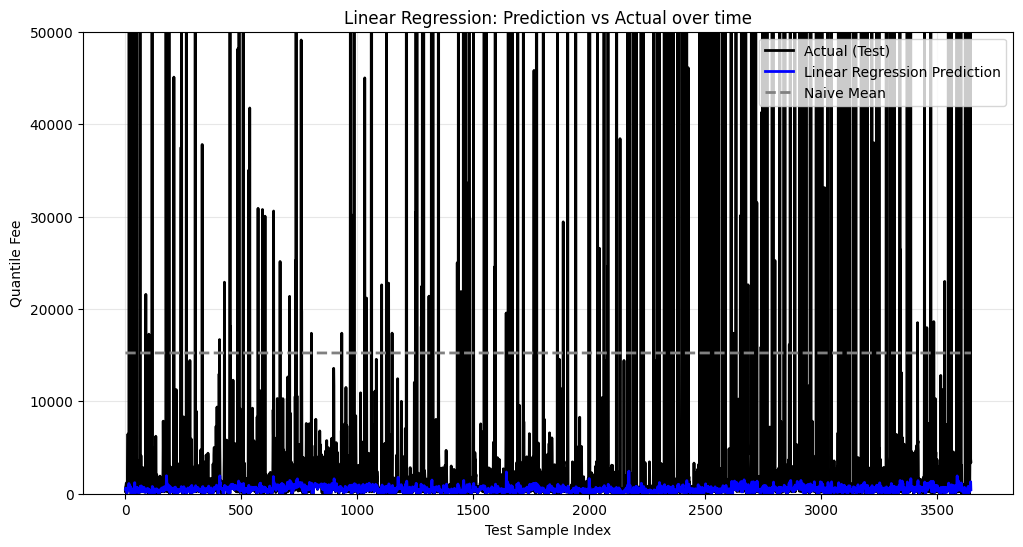

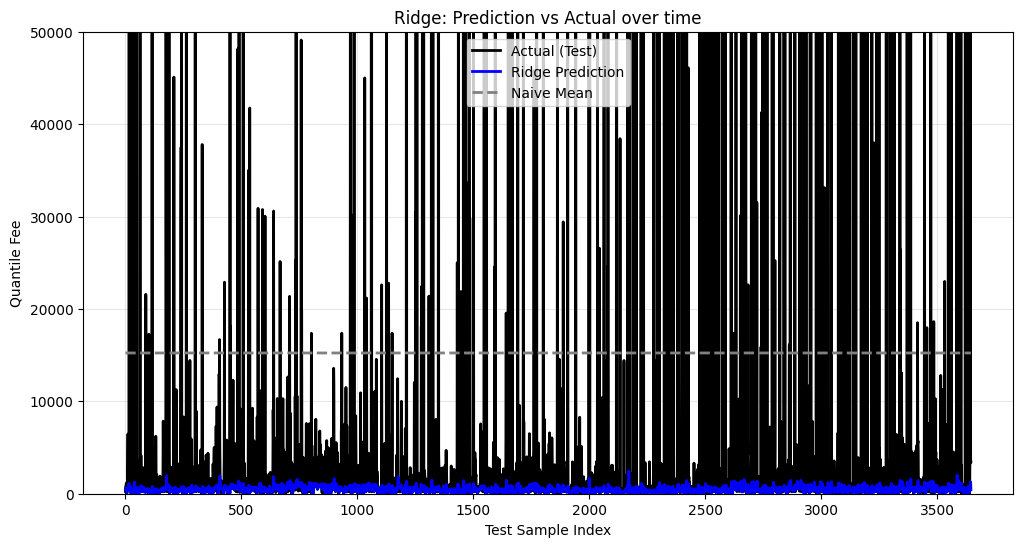

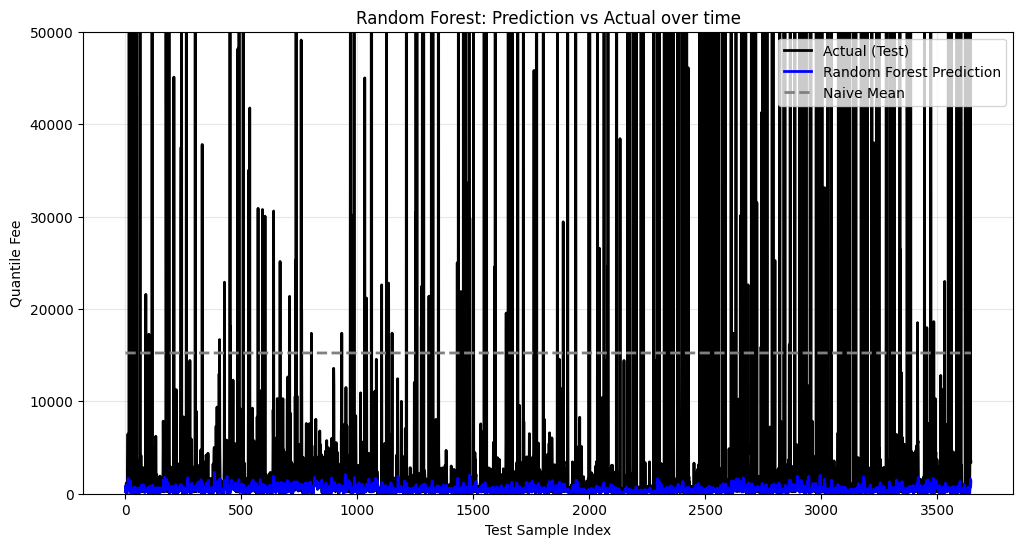

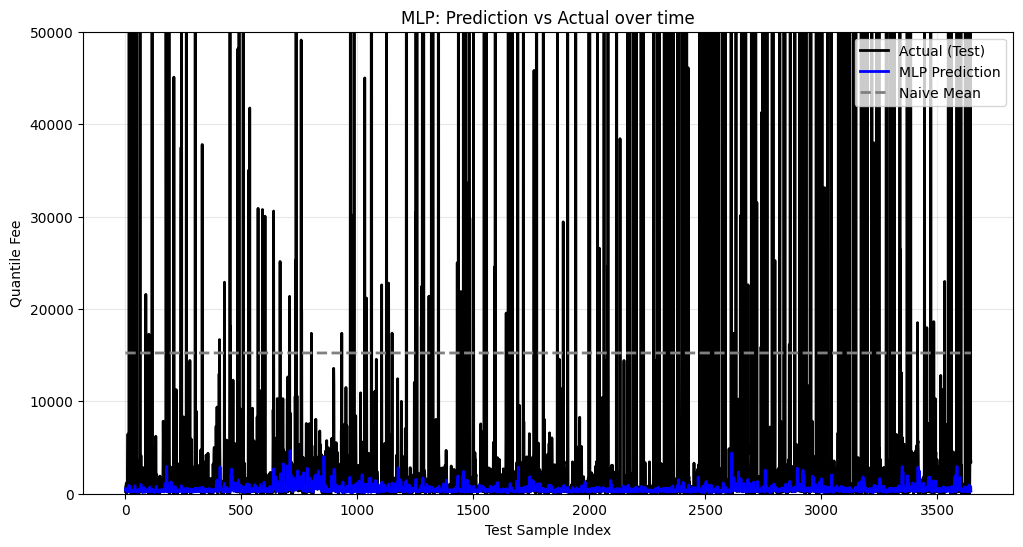

In [117]:
# Predictions over time plots for each model 


models = {
    "Linear Regression": linear_pred,
    "Ridge": ridge_pred,
    "Random Forest": forest_pred,
    "MLP": mlp_pred,
}

naive_pred = np.full_like(y_test_unclipped, y_test_unclipped.mean())

for model_name, pred in models.items():
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unclipped, label='Actual (Test)', color='black', linewidth=2)
    plt.plot(pred, label=f'{model_name} Prediction', color='blue', linewidth=2)
    plt.plot(naive_pred, label='Naive Mean', color='gray', linewidth=2, linestyle='--')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Quantile Fee')
    plt.title(f'{model_name}: Prediction vs Actual over time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 50000)
    plt.show()
# To the reader, the graphs have very little informative value if not zoomed in on a 100 blocks interval

Average % Above Prediction: 2409.8907405545356
Average % Below Prediction: 62.936842178502204


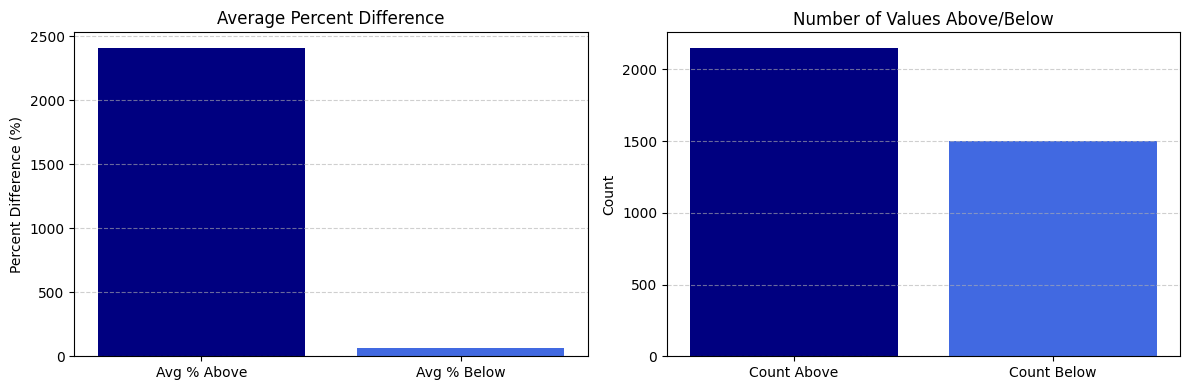

In [114]:
eps = 1e-9
safe_pred = np.where(linear_pred == 0, eps, linear_pred)

# Differences in percent
above_diff = (y_test - linear_pred) / safe_pred * 100   # positive when above
below_diff = (linear_pred - y_test) / safe_pred * 100   # positive when below

# Filter to only cases above / below
above_only = above_diff[y_test > linear_pred]
below_only = below_diff[y_test < linear_pred]

# Average differences
avg_above = above_only.mean() if len(above_only) > 0 else 0
avg_below = below_only.mean() if len(below_only) > 0 else 0

# Counts
num_above = len(above_only)
num_below = len(below_only)

print("Average % Above Prediction:", avg_above)
print("Average % Below Prediction:", avg_below)

# ==========================================
# Side-by-side plots
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Colors
color_above = "#000080"   # Navy
color_below = "#4169E1"   # Royal Blue

# ----- Plot 1: Average percent differences -----
axes[0].bar(["Avg % Above", "Avg % Below"], 
            [avg_above, avg_below], 
            color=[color_above, color_below])
axes[0].set_ylabel("Percent Difference (%)")
axes[0].set_title("Average Percent Difference")
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# ----- Plot 2: Counts -----
axes[1].bar(["Count Above", "Count Below"], 
            [num_above, num_below], 
            color=[color_above, color_below])
axes[1].set_ylabel("Count")
axes[1].set_title("Number of Values Above/Below")
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
